In [5]:
import warnings
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

warnings.filterwarnings("ignore")

# Spotify client credentials
client_credentials_manager = SpotifyClientCredentials(client_id=<id>,
                                                      client_secret=<secret>)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def albumSongs(uri):
    album = uri
    spotify_albums[album] = {}

    spotify_albums[album]['album'] = []
    spotify_albums[album]['track_number'] = []
    spotify_albums[album]['id'] = []
    spotify_albums[album]['name'] = []
    spotify_albums[album]['uri'] = []

    tracks = sp.album_tracks(album)
    for n in range(len(tracks['items'])):
        spotify_albums[album]['album'].append(album_names[album_count])
        spotify_albums[album]['track_number'].append(tracks['items'][n]['track_number'])
        spotify_albums[album]['id'].append(tracks['items'][n]['id'])
        spotify_albums[album]['name'].append(tracks['items'][n]['name'])
        spotify_albums[album]['uri'].append(tracks['items'][n]['uri'])

def audio_features(album):
    spotify_albums[album]['acousticness'] = []
    spotify_albums[album]['danceability'] = []
    spotify_albums[album]['energy'] = []
    spotify_albums[album]['instrumentalness'] = []
    spotify_albums[album]['liveness'] = []
    spotify_albums[album]['loudness'] = []
    spotify_albums[album]['speechiness'] = []
    spotify_albums[album]['tempo'] = []
    spotify_albums[album]['valence'] = []
    spotify_albums[album]['popularity'] = []

    track_count = 0
    for track in spotify_albums[album]['uri']:
        features = sp.audio_features(track)

        spotify_albums[album]['acousticness'].append(features[0]['acousticness'])
        spotify_albums[album]['danceability'].append(features[0]['danceability'])
        spotify_albums[album]['energy'].append(features[0]['energy'])
        spotify_albums[album]['instrumentalness'].append(features[0]['instrumentalness'])
        spotify_albums[album]['liveness'].append(features[0]['liveness'])
        spotify_albums[album]['loudness'].append(features[0]['loudness'])
        spotify_albums[album]['speechiness'].append(features[0]['speechiness'])
        spotify_albums[album]['tempo'].append(features[0]['tempo'])
        spotify_albums[album]['valence'].append(features[0]['valence'])

        pop = sp.track(track)
        spotify_albums[album]['popularity'].append(pop['popularity'])
        track_count += 1


name = input("Enter Name of Artist: ")

result = sp.search(name)
artist_uri = result['tracks']['items'][0]['artists'][0]['uri']

sp_albums = sp.artist_albums(artist_uri, album_type='album')

album_names = []
album_uris = []

for i in range(len(sp_albums['items'])):
    album_names.append(sp_albums['items'][i]['name'])
    album_uris.append(sp_albums['items'][i]['uri'])

spotify_albums = {}
album_count = 0

for i in album_uris:
    albumSongs(i)
    album_count += 1

sleep_min = 2
sleep_max = 5
start_time = time.time()
request_count = 0

for i in spotify_albums:
    audio_features(i)
    request_count += 1
    if request_count % 5 == 0:
        time.sleep(np.random.uniform(sleep_min, sleep_max))

dic_df = {}
dic_df['album'] = []
dic_df['track_number'] = []
dic_df['id'] = []
dic_df['name'] = []
dic_df['uri'] = []
dic_df['acousticness'] = []
dic_df['danceability'] = []
dic_df['energy'] = []
dic_df['instrumentalness'] = []
dic_df['liveness'] = []
dic_df['loudness'] = []
dic_df['speechiness'] = []
dic_df['tempo'] = []
dic_df['valence'] = []
dic_df['popularity'] = []

for album in spotify_albums:
    for feature in spotify_albums[album]:
        dic_df[feature].extend(spotify_albums[album][feature])

data = pd.DataFrame.from_dict(dic_df)


df = pd.read_csv('SpotifyDataAnalysis/data.csv')
data.drop_duplicates(inplace=True, subset=['name'])
df.drop_duplicates(inplace=True, subset=['name'])

data1 = pd.concat([data, df])


col_features = ['danceability', 'energy', 'valence', 'loudness']
X = MinMaxScaler().fit_transform(data1[col_features])

kmeans = KMeans(init="k-means++", n_clusters=16, random_state=15).fit(X)
data1['kmeans'] = kmeans.labels_

# Mapping clusters to classes
mapping = {
    0: "angry",
    1: "calm",
    2: "disgust",
    3: "fear",
    4: "happy",
    5: "neutral",
    6: "sad",
    7: "surprise",
    8: "angry",
    9: "calm",
    10: "disgust",
    11: "fear",
    12: "happy",
    13: "neutral",
    14: "sad",
    15: "surprise"
}

data1['mapped_class'] = data1['kmeans'].map(mapping)

# # Calculate silhouette score
# silhouette = silhouette_score(X, data1['kmeans'], metric='euclidean')
# print("Silhouette Score:", silhouette)

# Function to get recommended songs based on emotion code
def get_results(emotion_code):
    NUM_RECOMMEND = 10
    emotion_set = []

    if emotion_code == 0:
        emotion_set.append(data1[data1['mapped_class'] == 'angry']['name'].head(NUM_RECOMMEND))
    elif emotion_code == 1:
        emotion_set.append(data1[data1['mapped_class'] == 'calm']['name'].head(NUM_RECOMMEND))
    elif emotion_code == 2:
        emotion_set.append(data1[data1['mapped_class'] == 'disgust']['name'].head(NUM_RECOMMEND))
    elif emotion_code == 3:
        emotion_set.append(data1[data1['mapped_class'] == 'fear']['name'].head(NUM_RECOMMEND))
    elif emotion_code == 4:
        emotion_set.append(data1[data1['mapped_class'] == 'happy']['name'].head(NUM_RECOMMEND))
    elif emotion_code == 5:
        emotion_set.append(data1[data1['mapped_class'] == 'neutral']['name'].head(NUM_RECOMMEND))
    elif emotion_code == 6:
        emotion_set.append(data1[data1['mapped_class'] == 'sad']['name'].head(NUM_RECOMMEND))
    elif emotion_code == 7:
        emotion_set.append(data1[data1['mapped_class'] == 'surprise']['name'].head(NUM_RECOMMEND))

    return pd.DataFrame(emotion_set).T

# Function to display recommended songs
def final():
    global emotion_code
    if emotion_code is None:
        print("Error: Emotion code is not set. Please select an emotion first.")
        return

    df = get_results(emotion_code)
    print(df)

# Take emotion input from the user
emotion_code = int(input("Enter emotion code (0-7): "))

# Display recommended songs
final()

Enter Name of Artist:  Maroon 5


Silhouette Score: 0.2334824840454967


Enter emotion code (0-7):  0


                                                  name
29              Moves Like Jagger - Live In Manchester
34                      This Love - Live In Manchester
53                         Animals - Danny Olson Remix
54                             Animals - Gryffin Remix
81                                      Wipe Your Eyes
88                            Payphone - Cutmore Remix
133  Crazy Little Thing Called Love - Acoustic Version
136        Happy Christmas (War Is Over) - Bonus Track
165  If I Never See Your Face Again - Swizz Beatz R...
175            Little Of Your Time - Of Montreal Remix


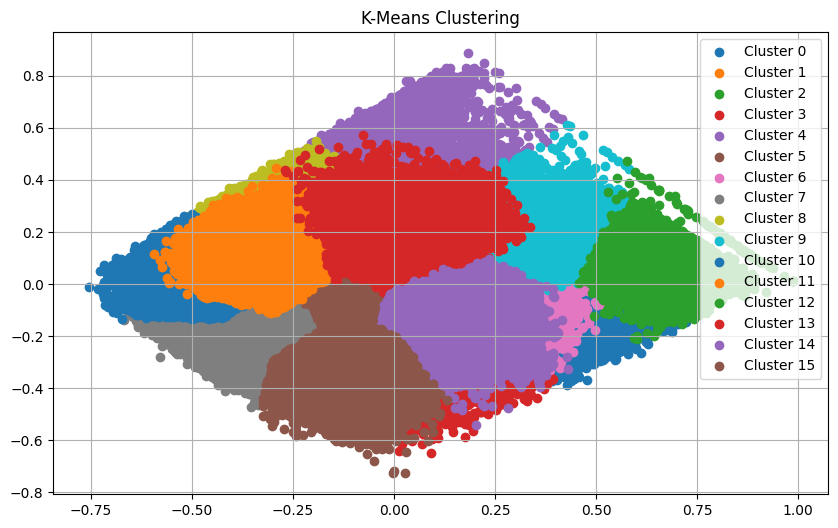

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(10, 6))

for i in range(16):  # Assuming 16 clusters
    plt.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], label=f'Cluster {i}')

plt.title('K-Means Clustering')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()